In [289]:
from datetime import date
import json

import openfisca_france
from openfisca_france.model.base import *

#importer numpy permet de coler deux sections de courbes (nécessaire quand on fait varier le salaire de base en-dessous du SMIC mensuel)
import numpy as np

# to debug / trace
from openfisca_core import periods, tools
from openfisca_core.reforms import Reform

# Système socio-fiscal

In [290]:
tax_benefit_system = openfisca_france.FranceTaxBenefitSystem()

In [291]:
simulation_year = 2016
simulation_period = periods.period(simulation_year)
simulation_first_month = simulation_period.this_month
simulation_start_instant = simulation_period.start

# Réforme : 1. Revenu de base par CSG

In [292]:
from numpy import logical_not as not_, minimum as min_, maximum as max_, logical_and as and_, logical_or as or_
#- Hausse de la CSG déductible au taux de 23%
#- Mise en place d'un revenu de base adulte égal à RSA socle célibataire - forfait logement célibataire
#- Intégrer le revenu de base au revenu disponible
#- Mise en place d'un crédit d'impot familles monoparentales montant ??? (50€)
#- Supprimer le RSA


#-Visualisation graphique en abscisse salaire brut et en ordonnée variation du revenu disponible 
# pour un célibataire sans enfant
# pour un couple sans enfant
# une famille monoparentale


#(- Nouveau calcul de l'IRPP)


In [293]:
#- Hausse de la CSG déductible au taux de 23%
#montant_csg_crds calcul à partir csg.activite.deductible.taux

def modify_legislation_json(reference_legislation_json_copy):
    for value_json in reference_legislation_json_copy['children']['csg']['children']['activite']['children']['deductible']['children']['taux']['values']:
        value_json['value'] = 0.23
    return reference_legislation_json_copy

In [294]:
#- Mise en place d'un revenu de base adulte égal à RSA socle célibataire - forfait logement célibataire

class rdb(Variable):
    column = FloatCol
    entity_class = Individus
    label = u"Revenu de base"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        age = simulation.calculate('age') 
        rmi = simulation.legislation_at(period.start).minim.rmi
        
        return period, ((age >= 18) * rmi.rmi * ( 1 -rmi.forfait_logement.taux1) + not_(age >= 18) * 0)

In [295]:
# On enlève les enfants du calcul du nbptr (quotient_familial.enf*)
class nbptr(Variable):
    def function(self, simulation, period):
        '''
        Nombre de parts du foyer
        'foy'
        note 1 enfants et résidence alternée (formulaire 2041 GV page 10)

        quotient_familial.conj : nb part associées au conjoint d'un couple marié ou pacsé
        quotient_familial.enf1 : nb part 2 premiers enfants
        quotient_familial.enf2 : nb part enfants de rang 3 ou plus
        quotient_familial.inv1 : nb part supp enfants invalides (I, G)
        quotient_familial.inv2 : nb part supp adultes invalides (R)
        quotient_familial.not31 : nb part supp note 3 : cases W ou G pour veuf, celib ou div
        quotient_familial.not32 : nb part supp note 3 : personne seule ayant élevé des enfants
        quotient_familial.not41 : nb part supp adultes invalides (vous et/ou conjoint) note 4
        quotient_familial.not42 : nb part supp adultes anciens combattants (vous et/ou conjoint) note 4
        quotient_familial.not6 : nb part supp note 6
        quotient_familial.isol : demi-part parent isolé (T)
        quotient_familial.edcd : enfant issu du mariage avec conjoint décédé;
        '''
        period = period.start.offset('first-of', 'month').period('year')
        nb_pac = simulation.calculate('nb_pac', period)
        maries_ou_pacses = simulation.calculate('maries_ou_pacses', period)
        celibataire_ou_divorce = simulation.calculate('celibataire_ou_divorce', period)
        veuf = simulation.calculate('veuf', period)
        jeune_veuf = simulation.calculate('jeune_veuf', period)
        nbF = simulation.calculate('nbF', period)
        nbG = simulation.calculate('nbG', period)
        nbH = simulation.calculate('nbH', period)
        nbI = simulation.calculate('nbI', period)
        nbR = simulation.calculate('nbR', period)
        nbJ = simulation.calculate('nbJ', period)
        caseP = simulation.calculate('caseP', period)
        caseW = simulation.calculate('caseW', period)
        caseG = simulation.calculate('caseG', period)
        caseE = simulation.calculate('caseE', period)
        caseK = simulation.calculate('caseK', period)
        caseN = simulation.calculate('caseN', period)
        caseF = simulation.calculate('caseF', period)
        caseS = simulation.calculate('caseS', period)
        caseL = simulation.calculate('caseL', period)
        caseT = simulation.calculate('caseT', period)
        quotient_familial = simulation.legislation_at(period.start).ir.quotient_familial

        no_pac = nb_pac == 0  # Aucune personne à charge en garde exclusive
        has_pac = not_(no_pac)
        no_alt = nbH == 0  # Aucun enfant à charge en garde alternée
        has_alt = not_(no_alt)

        # # nombre de parts liées aux enfants à charge
        # que des enfants en résidence alternée
        enf1 = (no_pac & has_alt) * (quotient_familial.enf1 * min_(nbH, 2) * 0.5
                                     + quotient_familial.enf2 * max_(nbH - 2, 0) * 0.5)
        # pas que des enfants en résidence alternée
        enf2 = (has_pac & has_alt) * ((nb_pac == 1) * (quotient_familial.enf1 * min_(nbH, 1) * 0.5
            + quotient_familial.enf2 * max_(nbH - 1, 0) * 0.5) + (nb_pac > 1) * (quotient_familial.enf2 * nbH * 0.5))
        # pas d'enfant en résidence alternée
        enf3 = quotient_familial.enf1 * min_(nb_pac, 2) + quotient_familial.enf2 * max_((nb_pac - 2), 0)

        enf = enf1 + enf2 + enf3
        # # note 2 : nombre de parts liées aux invalides (enfant + adulte)
        n2 = quotient_familial.inv1 * (nbG + nbI / 2) + quotient_familial.inv2 * nbR

        # # note 3 : Pas de personne à charge
        # - invalide

        n31a = quotient_familial.not31a * (no_pac & no_alt & caseP)
        # - ancien combatant
        n31b = quotient_familial.not31b * (no_pac & no_alt & (caseW | caseG))
        n31 = max_(n31a, n31b)
        # - personne seule ayant élevé des enfants
        n32 = quotient_familial.not32 * (no_pac & no_alt & ((caseE | caseK) & not_(caseN)))
        n3 = max_(n31, n32)
        # # note 4 Invalidité de la personne ou du conjoint pour les mariés ou
        # # jeunes veuf(ve)s
        n4 = max_(quotient_familial.not41 * (1 * caseP + 1 * caseF), quotient_familial.not42 * (caseW | caseS))

        # # note 5
        #  - enfant du conjoint décédé
        n51 = quotient_familial.cdcd * (caseL & ((nbF + nbJ) > 0))
        #  - enfant autre et parent isolé
        n52 = quotient_familial.isol * caseT * (((no_pac & has_alt) * ((nbH == 1) * 0.5 + (nbH >= 2))) + 1 * has_pac)
        n5 = max_(n51, n52)

        # # note 6 invalide avec personne à charge
        n6 = quotient_familial.not6 * (caseP & (has_pac | has_alt))

        # # note 7 Parent isolé
        n7 = quotient_familial.isol * caseT * ((no_pac & has_alt) * ((nbH == 1) * 0.5 + (nbH >= 2)) + 1 * has_pac)

        # # Régime des mariés ou pacsés
        #m = 1 + quotient_familial.conj + enf + n2 + n4
        m = 1 + quotient_familial.conj + n2 + n4
        
        # # veufs  hors jeune_veuf
        # v = 1 + enf + n2 + n3 + n5 + n6
        v = 1 + n2 + n3 + n5 + n6
        
        # # celib div
        #c = 1 + enf + n2 + n3 + n6 + n7
        c = 1 + n2 + n3 + n6 + n7

        return period, (maries_ou_pacses | jeune_veuf) * m + (veuf & not_(jeune_veuf)) * v + celibataire_ou_divorce * c


In [296]:
# Suppression des allocations familiales

class af(Variable):
    def function(self, simulation, period):
        period = period.this_month
        af_base = simulation.calculate('af_base', period)
        af_majoration = simulation.calculate('af_majoration', period)
        af_allocation_forfaitaire = simulation.calculate('af_allocation_forfaitaire', period)

        #return period, af_base + af_majoration + af_allocation_forfaitaire
        return period, af_base * 0

In [297]:
from numpy import round

# Suppression du complément familial

class cf(Variable):
    def function(self, simulation, period):
        '''
        L'allocation de base de la paje n'est pas cumulable avec le complément familial
        '''
        period = period.this_month
        paje_base = simulation.calculate('paje_base', period)
        apje_avant_cumul = simulation.calculate('apje_avant_cumul', period)
        ape_avant_cumul = simulation.calculate('ape_avant_cumul', period)
        cf_montant = simulation.calculate('cf_montant', period)
        residence_mayotte = simulation.calculate('residence_mayotte', period)

        cf_brut = not_(paje_base) * (apje_avant_cumul <= cf_montant) * (ape_avant_cumul <= cf_montant) * cf_montant
        # return period, not_(residence_mayotte) * round(cf_brut, 2)
        return period, not_(residence_mayotte) * round(cf_brut, 2) * 0

In [298]:
# Suppression de l'allocation de rentrée scolaire

class ars(Variable):
    def function(self, simulation, period):
        '''
        Allocation de rentrée scolaire brute de CRDS
        '''
        period_br = period.this_year
        return period_br, self.zeros()

In [299]:
# Création d'un revenu de base enfant - Version individus au niveau des allocations familliales actuelles

class rdb_enf(Variable):
    column = FloatCol
    entity_class = Individus
    label = u"Revenu de base enfant"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        age = simulation.calculate('age')
        P = simulation.legislation_at(period.start).fam.af        
        bmaf = P.bmaf
        
        return period, ((age < 14) * 0.41 + not_(age < 14) * 0.57) * bmaf * (age <= 18)

In [300]:
#- Mise en place d'un crédit d'impot familles monoparentales montant (150€)
class credit_impot_monoparentales(Variable):
    column = FloatCol
    entity_class = Menages
    label = u"credit_impot_monoparentales"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        enfant_a_charge_holder = simulation.compute('enfant_a_charge', period)
        enfant_a_charge = self.sum_by_entity(enfant_a_charge_holder)
        caseT = simulation.calculate('caseT', period) #Egal True si le parent est isolé
      
        #return period, or_(and_(age_holder >= 18, nb_enf_a_charge > 0, caseT), or_(age_holder < 18, nb_enf_a_charge <= 0, not_(caseT)) * 0) * 100
        return period, (enfant_a_charge > 0) * caseT * 150
    #Si le parent est isolé, avec au moins un enfant, et qu'il est majeur il reçoit la pension

In [301]:
#- Supprimer le RSA
class rsa_socle(Variable):
    def function(self, simulation, period):
        period = period.this_month
        nb_parents = simulation.calculate('nb_parents', period)
        eligib = simulation.calculate('rsa_eligibilite', period)
        rsa_nb_enfants = simulation.calculate('rsa_nb_enfants', period)
        rmi = simulation.legislation_at(period.start).minim.rmi

        nbp = nb_parents + rsa_nb_enfants

        taux = (
            1 +
            (nbp >= 2) * rmi.txp2 +
            (nbp >= 3) * rmi.txp3 +
            (nbp >= 4) * ((nb_parents == 1) * rmi.txps + (nb_parents != 1) * rmi.txp3) +
            max_(nbp - 4, 0) * rmi.txps
        )
        #on met à zéro
        return period, eligib * rmi.rmi * taux * 0

In [302]:
#- Intégrer le revenu de base au revenu disponible
class revdisp(Variable):
    def function(self, simulation, period):
        '''
        Revenu disponible - ménage
        'men'
        '''
        period = period.start.period('year').offset('first-of')
        rev_trav_holder = simulation.compute('rev_trav', period)
        pen_holder = simulation.compute('pen', period)
        rev_cap_holder = simulation.compute('rev_cap', period)
        psoc_holder = simulation.compute('psoc', period)
        ppe_holder = simulation.compute('ppe', period)
        impo = simulation.calculate('impo', period)
        rdb_holder = simulation.calculate_add('rdb', period)
        credit_impot_familles_holder = simulation.calculate_add('credit_impot_monoparentales', period)
        rdb_enf_holder = simulation.calculate_add('rdb_enf', period)

        pen = self.sum_by_entity(pen_holder)
        ppe = self.cast_from_entity_to_role(ppe_holder, role = VOUS)
        ppe = self.sum_by_entity(ppe)
        psoc = self.cast_from_entity_to_role(psoc_holder, role = CHEF)
        psoc = self.sum_by_entity(psoc)
        rev_cap = self.sum_by_entity(rev_cap_holder)
        rev_trav = self.sum_by_entity(rev_trav_holder)
        rdb = self.sum_by_entity(rdb_holder)
        rdb_enf = self.sum_by_entity(rdb_enf_holder)
        
        return period, rev_trav + pen + rev_cap + psoc + ppe + impo + rdb + credit_impot_familles_holder + rdb_enf

In [303]:
class ReformeRevenuDeBaseparCSG(Reform):
    name = u"Réforme Revenu de base par CSG"

    def apply(self):
        for variable in [rdb, nbptr, af, cf, ars, rdb_enf, credit_impot_monoparentales, rsa_socle, revdisp]:
            self.update_variable(variable)
        self.modify_legislation_json(modifier_function = modify_legislation_json)

# Tests

In [304]:
reform = ReformeRevenuDeBaseparCSG(tax_benefit_system)

In [305]:
parent1_salaire_de_base = 60000

In [336]:
scenario_ref_individu_seul = tax_benefit_system.new_scenario().init_single_entity(
    period = 2014,
    parent1 = dict(
        date_naissance = date(1980, 1, 1),
        salaire_de_base = parent1_salaire_de_base,
        statut_marital = u'Célibataire',
        ),
    foyer_fiscal = dict(
        caseT = True,
        ),
    enfants = [
        dict(
            date_naissance = date(2010, 1, 1),
            ),
        ],
    )

In [307]:
simulation_ref_individu_seul = scenario_ref_individu_seul.new_simulation(debug = True)

In [308]:
scenario_rdb_individu_seul = reform.new_scenario().init_single_entity(
    period = 2014,
    parent1 = dict(
        date_naissance = date(1980, 1, 1),
        salaire_de_base = parent1_salaire_de_base,
        statut_marital = u'Célibataire',
        ),
    foyer_fiscal = dict(
        caseT = True,
        ),
    enfants = [
        dict(
            date_naissance = date(2010, 1, 1),
            ),
        ],
    )

In [309]:
simulation_rdb_individu_seul = scenario_rdb_individu_seul.new_simulation(debug = True)

Calculs de référence (revenu disponible, IR, RSA, CSG imposable/deductible, impot total) 

In [310]:
simulation_ref_individu_seul.calculate('revdisp')

array([ 46916.54296875], dtype=float32)

In [311]:
simulation_ref_individu_seul.calculate('irpp')

array([-4019.29296875], dtype=float32)

In [312]:
simulation_rdb_individu_seul.calculate_add('rdb_enf')

array([    0.        ,  1995.57678223], dtype=float32)

In [313]:
simulation_ref_individu_seul.calculate_add('rsa')

array([ 658.11230469], dtype=float32)

In [314]:
simulation_ref_individu_seul.calculate('csg_imposable_salaire')

array([-1414.8001709,    -0.       ], dtype=float32)

In [315]:
simulation_ref_individu_seul.calculate('csg_deductible_salaire')

array([-3006.45019531,    -0.        ], dtype=float32)

In [316]:
simulation_ref_individu_seul.calculate('tot_impot')

array([ 8744.265625], dtype=float32)

Calculs avec réforme RDB (revenu disponible, IR, RSA, CSG imposable/deductible, impot total) 

In [317]:
simulation_rdb_individu_seul.calculate('revdisp')

array([ 45681.765625], dtype=float32)

In [318]:
simulation_rdb_individu_seul.calculate('irpp')

array([-2949.17675781], dtype=float32)

In [319]:
simulation_rdb_individu_seul.calculate('csg_deductible_salaire')

array([-13558.5,     -0. ], dtype=float32)

In [320]:
simulation_rdb_individu_seul.calculate('tot_impot')

array([ 18222.90820312], dtype=float32)

In [321]:
# trace
simulation_rdb_individu_seul.calculate('tot_impot')
#print web_tools.get_trace_tool_link(scenario, ['tot_impot'])

array([ 18222.90820312], dtype=float32)

# Graphiques: scenario variant selon salaire_de_base (0 => 60k par palier de 5k)
nb_pla = 5000
min_salaire_de_base = 0
max_salaire_de_base = 60000

## Préalable : Pour avoir des graphiques cohérents, on crée une variable "salaire_de_base" = salaire horaire brut x volume horaire qui varie de 0 € à 60.000 € telles que 
-> entre 0 € et le SMIC mensuel, salaire horaire brut = SMIC horaire brut et c'est le nombre d'heures qui varie

-> du SMIC mensuel à au-delà, c'est le salaire horaire brut qui augmente

In [322]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [323]:
date_naissance_parent1 = date(1980, 1, 1)

In [324]:
# Législation en 2016
legislation_2016 = tax_benefit_system.get_compact_legislation(instant=simulation_start_instant)

smic_horaire = legislation_2016.cotsoc.gen.smic_h_b
print('smic_horaire = {}'.format(smic_horaire))

nb_heures_par_an_temps_plein = legislation_2016.ir.credits_impot.ppe.TP_nbh
nb_heures_par_mois_temps_plein = nb_heures_par_an_temps_plein / 12.0
print('nb_heures_par_mois_temps_plein = {}'.format(nb_heures_par_mois_temps_plein))

smic_horaire = 9.67
nb_heures_par_mois_temps_plein = 151.666666667


In [325]:
def calculate_under_and_over_smic(tax_benefit_system, variable_name, month_period, parent1, salaire_de_base_max,
                                  enfants=None, nb_steps_under_smic=10, nb_steps_over_smic=50):
    # On commence par simuler la variation de salaire entre 0 € et le SMIC mensuel
    # Entre 0 € et le SMIC mensuel, quand le salaire de base augmente, c'est le volume horaire qui augmente (de 0 à 35 heures hendomadaires)
    # Le salaire horaire quant à lui reste fixé au SMIC horaire
    # On divise donc le segment [0 € - SMIC mensuel] en 10 paliers, en faisant augmenter parallèlement à chaque palier les variables nb_heures_par_mois_temps_plein et salaire_de_base 

    legislation_2016 = tax_benefit_system.get_compact_legislation(instant=month_period.start)
    smic_horaire = legislation_2016.cotsoc.gen.smic_h_b
    nb_heures_par_an_temps_plein = legislation_2016.ir.credits_impot.ppe.TP_nbh
    nb_heures_par_mois_temps_plein = nb_heures_par_an_temps_plein / 12.0
    smic_mensuel = nb_heures_par_mois_temps_plein * smic_horaire

    last_months = periods.period('month', month_period.offset(-5).start, 6)

    # Under SMIC

    scenario_under_smic = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            [
                dict(
                    count = nb_steps_under_smic,
                    min = 0,
                    max = nb_heures_par_mois_temps_plein,
                    name = 'heures_remunerees_volume',
                    period = periods.period('month', last_months.offset(index).start, 1),
                    )
                for index in xrange(last_months.size)
                ] + \
            [
                dict(
                    count = nb_steps_under_smic,
                    min = 0,
                    max = smic_mensuel,
                    name = 'salaire_de_base',
                    period = periods.period('month', last_months.offset(index).start, 1),
                    )
                for index in xrange(last_months.size)
                ],
            ],
        period = month_period,
        parent1 = dict(list(parent1.items()) + list(dict(
            contrat_de_travail = 1, # temps partiel
            ).items())),
        enfants=enfants,
        )
    simulation_under_smic = scenario_under_smic.new_simulation()
    salaire_de_base_under_smic = simulation_under_smic.calculate('salaire_de_base', month_period)
    variable_under_smic = simulation_under_smic.calculate(variable_name, month_period)

    # Over SMIC

    scenario_over_smic = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            [
                dict(
                    count = nb_steps_over_smic,
                    min = smic_mensuel,
                    max = salaire_de_base_max,
                    name = 'salaire_de_base',
                    period = periods.period('month', last_months.offset(index).start, 1),
                    )
                for index in xrange(last_months.size)
                ],
            ],
        period = month_period,
        parent1 = dict(list(parent1.items()) + list(dict(
            contrat_de_travail = 0, # temps plein
            ).items())),
        enfants=enfants,
        )
    simulation_over_smic = scenario_over_smic.new_simulation()
    salaire_de_base_over_smic = simulation_over_smic.calculate('salaire_de_base', month_period)
    variable_over_smic = simulation_over_smic.calculate(variable_name, month_period)

    salaire_de_base = np.concatenate([salaire_de_base_under_smic, salaire_de_base_over_smic])
    variable = np.concatenate([variable_under_smic, variable_over_smic])
    return salaire_de_base, variable

allegement_fillon

In [326]:
salaire_de_base, allegement_fillon = calculate_under_and_over_smic(
    tax_benefit_system=tax_benefit_system,
    variable_name='allegement_fillon',
    month_period=simulation_first_month,
    parent1=dict(
        date_naissance = date(1980, 1, 1),
        allegement_fillon_mode_recouvrement = 1, # anticipe_regularisation_fin_de_periode
        ),
    enfants=[
        dict(
            date_naissance = date(2005, 1, 1),
            ),
        ],
    salaire_de_base_max=5000,
    )
# print(salaire_de_base[::2])
# print(allegement_fillon[::2])

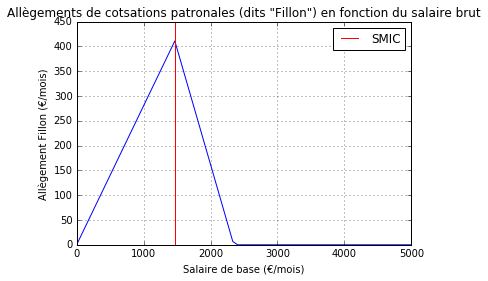

In [327]:
# Crade, il faudrait disposer d'une fonction qui renvoie les résultats par rôle
salaire_de_base_parent1 = salaire_de_base[::2]
allegement_fillon_parent1 = allegement_fillon[::2]

plt.plot(salaire_de_base_parent1, allegement_fillon_parent1)
plt.xlabel(u'Salaire de base (€/mois)')
plt.ylabel(u'Allègement Fillon (€/mois)')
plt.title(u'Allègements de cotsations patronales (dits "Fillon") en fonction du salaire brut')
plt.grid(True)
plt.axvline(x=smic_mensuel, color='r', label='SMIC')
plt.legend()
plt.show()

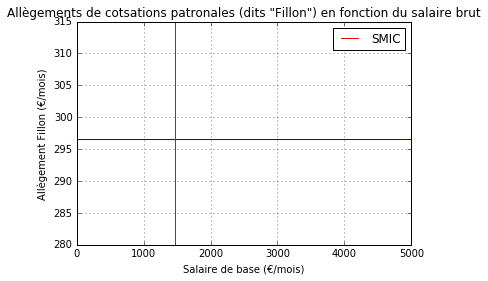

In [328]:
salaire_de_base, af = calculate_under_and_over_smic(
    tax_benefit_system=tax_benefit_system,
    variable_name='af',
    month_period=simulation_first_month,
    parent1=dict(
        date_naissance = date(1980, 1, 1),
        ),
    enfants=[
        dict(
            date_naissance = date(2005, 1, 1),
            ),
        ] * 3,
    salaire_de_base_max=5000,
    )
plt.plot(salaire_de_base[::4], af)
plt.xlabel(u'Salaire de base (€/mois)')
plt.ylabel(u'Allocations Familiales (€/mois)')
plt.title(u'Allocations Familiales en fonction du salaire brut pour une famille avec 3 enfants')
plt.grid(True)
plt.axvline(x=smic_mensuel, color='r', label='SMIC')
plt.legend()
plt.show()

RSA + PPA

In [329]:
salaire_de_base, rsa = calculate_under_and_over_smic(
    tax_benefit_system=tax_benefit_system,
    variable_name='rsa',
    month_period=simulation_first_month,
    parent1=dict(
        date_naissance = date(1980, 1, 1),
        ),
    salaire_de_base_max=5000,
    )
_, ppa = calculate_under_and_over_smic(
    tax_benefit_system=tax_benefit_system,
    variable_name='ppa',
    month_period=simulation_first_month,
    parent1=dict(
        date_naissance = date(1980, 1, 1),
        ),
    salaire_de_base_max=5000,
    )

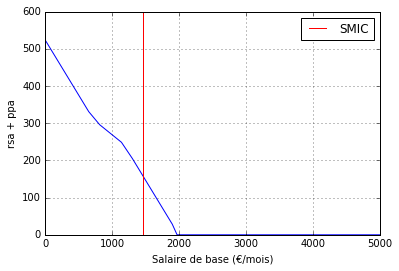

In [330]:
plt.plot(salaire_de_base, rsa + ppa)
plt.xlabel(u'Salaire de base (€/mois)')
plt.ylabel(u'rsa + ppa')
plt.grid(True)
plt.axvline(x=smic_mensuel, color='r', label='SMIC')
plt.legend()
plt.show()

Générer plusieurs graphiques dans une boucle "for"

In [331]:
def plot_under_and_over_smic(tax_benefit_system, variable_name, month_period, parent1, salaire_de_base_max,
                             enfants=None, nb_steps_under_smic=10, nb_steps_over_smic=50):
    salaire_de_base, variable = calculate_under_and_over_smic(
        tax_benefit_system, variable_name, month_period, parent1,
        salaire_de_base_max, enfants, nb_steps_under_smic, nb_steps_over_smic)
    plt.plot(salaire_de_base, variable)
    plt.xlabel(u'Salaire de base (€/mois)')
    plt.ylabel(variable_name)
    plt.grid(True)

    # Draw vertical line for SMIC
    legislation_2016 = tax_benefit_system.get_compact_legislation(instant=month_period.start)
    smic_horaire = legislation_2016.cotsoc.gen.smic_h_b
    nb_heures_par_an_temps_plein = legislation_2016.ir.credits_impot.ppe.TP_nbh
    nb_heures_par_mois_temps_plein = nb_heures_par_an_temps_plein / 12.0
    smic_mensuel = nb_heures_par_mois_temps_plein * smic_horaire
    plt.axvline(x=smic_mensuel, color='r', label='SMIC')
    plt.legend()

    plt.show()

ValueError: x and y must have same first dimension

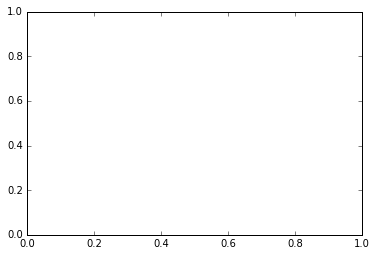

In [332]:
plot_under_and_over_smic(
    tax_benefit_system=tax_benefit_system,
    variable_name='af',
    month_period=simulation_first_month,
    parent1=dict(
        date_naissance = date(1980, 1, 1),
        allegement_fillon_mode_recouvrement = 1, # anticipe_regularisation_fin_de_periode
        ),
    enfants=[
        dict(
            date_naissance = date(2005, 1, 1),
            ),
        ],
    salaire_de_base_max=5000,
    )

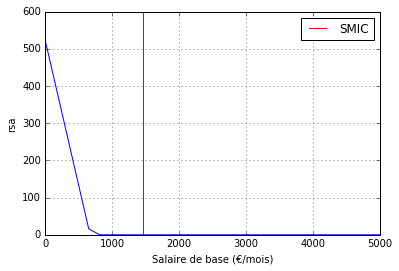

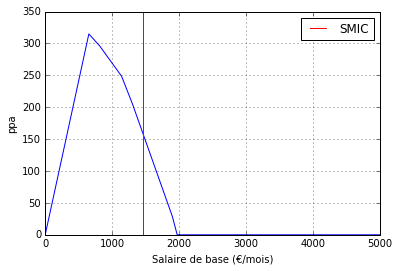

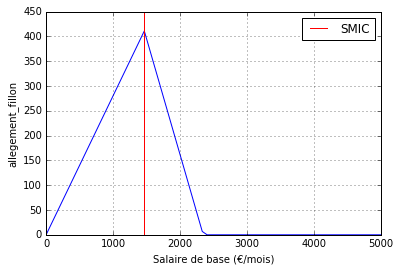

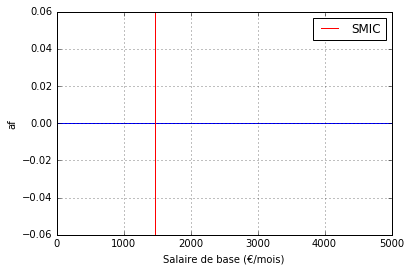

In [335]:
for variable_name in ('rsa', 'ppa', 'allegement_fillon', 'af'):
    plot_under_and_over_smic(
        tax_benefit_system=tax_benefit_system,
        variable_name=variable_name,
        month_period=simulation_first_month,
        parent1=dict(
            date_naissance = date(1980, 1, 1),
            allegement_fillon_mode_recouvrement = 1, # anticipe_regularisation_fin_de_periode
            ),
        salaire_de_base_max=5000,
        )

Ancienne version, manuelle (sans fonction pour factoriser le code)

In [ ]:
# On commence par simuler la variation de salaire entre 0 € et le SMIC mensuel
# Entre 0 € et le SMIC mensuel, quand le salaire de base augmente, c'est le volume horaire qui augmente (de 0 à 35 heures hendomadaires)
# Le salaire horaire quant à lui reste fixé au SMIC horaire
# On divise donc le segment [0 € - SMIC mensuel] en 10 paliers, en faisant augmenter parallèlement à chaque palier les variables nb_heures_par_mois_temps_plein et salaire_de_base 

scenario_under_smic = tax_benefit_system.new_scenario().init_single_entity(
    axes = [
        [
            dict(
                count = 10,
                min = 0,
                max = nb_heures_par_mois_temps_plein,
                name = 'heures_remunerees_volume',
                ),
            dict(
                count = 10,
                min = 0,
                max = nb_heures_par_mois_temps_plein * smic_horaire,
                name = 'salaire_de_base',
                ),
            ],
        ],
    period = simulation_first_month,
    parent1 = dict(
        date_naissance = date_naissance_parent1,
        contrat_de_travail = 1, # temps partiel
        allegement_fillon_mode_recouvrement = 1, # anticipe_regularisation_fin_de_periode
        ),
    )

In [ ]:
simulation_under_smic = scenario_under_smic.new_simulation()

In [ ]:
salaire_de_base_under_smic = simulation_under_smic.calculate('salaire_de_base', simulation_first_month)
salaire_de_base_under_smic

In [ ]:
# On simule l'évolution des allègements Fillon sur ce segment

allegement_fillon_under_smic = simulation_under_smic.calculate('allegement_fillon', simulation_first_month)
allegement_fillon_under_smic

In [ ]:
plt.plot(salaire_de_base_under_smic, allegement_fillon_under_smic)
plt.xlabel(u'Salaire de base (€/mois)')
plt.ylabel(u'Allègement Fillon (€/mois)')
plt.title(u'Au-dessous du SMIC')
plt.grid(True)
plt.show()

In [ ]:
smic_mensuel = nb_heures_par_mois_temps_plein * smic_horaire
smic_mensuel

In [ ]:
# Au-delà du SMIC mensuel, on suppose que le volume horaire reste fixé à 35 heures,
# et que c'est le salaire horaire qui augmente

scenario_over_smic = tax_benefit_system.new_scenario().init_single_entity(
    axes = [
        dict(
            count = 50,
            min = smic_mensuel,
            max = 5000,
            name = 'salaire_de_base',
            ),
        ],
    period = simulation_first_month,
    parent1 = dict(
        date_naissance = date_naissance_parent1,
        contrat_de_travail = 0, # temps plein
        allegement_fillon_mode_recouvrement = 1, # anticipe_regularisation_fin_de_periode
        ),
    )

In [ ]:
simulation_over_smic = scenario_over_smic.new_simulation()

In [ ]:
salaire_de_base_over_smic = simulation_over_smic.calculate('salaire_de_base', simulation_first_month)
salaire_de_base_over_smic

In [ ]:
allegement_fillon_over_smic = simulation_over_smic.calculate('allegement_fillon', simulation_first_month)
allegement_fillon_over_smic

In [ ]:
plt.plot(salaire_de_base_over_smic, allegement_fillon_over_smic)
plt.xlabel(u'Salaire de base (€/mois)')
plt.ylabel(u'Allègement Fillon (€/mois)')
plt.title(u'Au-dessus du SMIC')
plt.grid(True)
plt.show()

In [ ]:
# On crée ici la variable "salaire_de_base" qui est l'enchainement du segment : 0 €- SMIC mensuel et du segment SMIC mensuel - au-delà
# le crochet [:-1] permet d'éviter que l'on ait l'observation "SMIC mensuel" en doublon

salaire_de_base = np.concatenate([salaire_de_base_under_smic[:-1], salaire_de_base_over_smic])

In [ ]:
allegement_fillon = np.concatenate([allegement_fillon_under_smic[:-1], allegement_fillon_over_smic])

In [ ]:
plt.plot(salaire_de_base, allegement_fillon)
# plt.plot(salaire_de_base_under_smic, allegement_fillon_under_smic, label=u'Temps partiel de 0 à 35h/mois')
# plt.plot(salaire_de_base_over_smic, allegement_fillon_over_smic, label=u'Temps plein')
plt.xlabel(u'Salaire de base (€/mois)')
plt.ylabel(u'Allègement Fillon (€/mois)')
plt.title(u'Allègements de cotsations patronales (dits "Fillon") en fonction du salaire brut')
plt.grid(True)
plt.axvline(x=smic_mensuel, color='r', label='SMIC')
plt.legend()
plt.show()

Graph de l'évolution su salaire super-brut en fonction du salaire brut

In [ ]:
salaire_super_brut_under_smic = simulation_under_smic.calculate('salaire_super_brut', simulation_first_month)
salaire_super_brut_over_smic = simulation_over_smic.calculate('salaire_super_brut', simulation_first_month)

salaire_super_brut = np.concatenate([salaire_super_brut_under_smic[:-1], salaire_super_brut_over_smic])

plt.plot(salaire_de_base, salaire_super_brut)
plt.xlabel(u'Salaire de base (€/mois)')
plt.ylabel(u'Salaire super-brut (€/mois)')
plt.title(u'Salaire super-brut en fonction du salaire brut (compte-tenu des allègements de cotisations dits "Fillon")')
plt.grid(True)
plt.axvline(x=smic_mensuel, color='r', label='SMIC')
plt.legend()
plt.show()

In [ ]:
min_salaire_de_base = 0
max_salaire_de_base = 120000
pas = 5000
nb_palier = max_salaire_de_base / pas

In [ ]:
def make_two_parents_scenario(nombre_enfants = 1, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        date_naissance = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        parent2 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 5000,
            statut_occupation_logement = 4,
            ),
        )
    return scenario

In [ ]:
def make_one_parent_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        date_naissance = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 5000,
            statut_occupation_logement = 4,
            ),
        )
    return scenario

In [ ]:
scenario_p2_e0_ref = make_two_parents_scenario(0, simulation_period)
simulation_p2_e0_ref = scenario_p2_e0_ref.new_simulation()

In [ ]:
scenario_p2_e0_rdb = make_two_parents_scenario(0, simulation_period, reform)
simulation_p2_e0_rdb = scenario_p2_e0_rdb.new_simulation()

In [ ]:
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p2_e0_ref = simulation_p2_e0_ref.calculate_add("revdisp") / 12
revenu_disponible_p2_e0_rdb = simulation_p2_e0_rdb.calculate_add("revdisp") / 12

salaire_de_base_p2_e0_ref = simulation_p2_e0_ref.calculate("salaire_de_base") / 12
salaire_de_base_p2_e0_rdb = simulation_p2_e0_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p2_e0_ref[::2], revenu_disponible_p2_e0_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p2_e0_rdb[::2], revenu_disponible_p2_e0_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un couple de salaries sans enfant, {}".format(simulation_year))
plt.grid()
plt.legend(loc=2)

In [ ]:
scenario_p2_e1_ref = make_two_parents_scenario(1, simulation_period)
simulation_p2_e1_ref = scenario_p2_e1_ref.new_simulation()
scenario_p2_e1_rdb = make_two_parents_scenario(1, simulation_period, reform)
simulation_p2_e1_rdb = scenario_p2_e1_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p2_e1_ref = simulation_p2_e1_ref.calculate_add("revdisp") / 12
revenu_disponible_p2_e1_rdb = simulation_p2_e1_rdb.calculate_add("revdisp") / 12

salaire_de_base_p2_e1_ref = simulation_p2_e1_ref.calculate("salaire_de_base") / 12
salaire_de_base_p2_e1_rdb = simulation_p2_e1_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p2_e1_ref[::3], revenu_disponible_p2_e1_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p2_e1_rdb[::3], revenu_disponible_p2_e1_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un couple de salaries avec 1 enfant, {}".format(simulation_year))
plt.grid()
plt.legend(loc=2)

In [ ]:
scenario_p2_e2_ref = make_two_parents_scenario(2, simulation_period)
simulation_p2_e2_ref = scenario_p2_e2_ref.new_simulation()
scenario_p2_e2_rdb = make_two_parents_scenario(2, simulation_period, reform)
simulation_p2_e2_rdb = scenario_p2_e2_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p2_e2_ref = simulation_p2_e2_ref.calculate_add("revdisp") / 12
revenu_disponible_p2_e2_rdb = simulation_p2_e2_rdb.calculate_add("revdisp") / 12

salaire_de_base_p2_e2_ref = simulation_p2_e2_ref.calculate("salaire_de_base") / 12
salaire_de_base_p2_e2_rdb = simulation_p2_e2_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p2_e2_ref[::4], revenu_disponible_p2_e2_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p2_e2_rdb[::4], revenu_disponible_p2_e2_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un couple de salaries avec 2 enfants, {}".format(simulation_year))
plt.grid()
plt.legend(loc=2)

In [ ]:
scenario_p2_e3_ref = make_two_parents_scenario(3, simulation_period)
simulation_p2_e3_ref = scenario_p2_e3_ref.new_simulation()
scenario_p2_e3_rdb = make_two_parents_scenario(3, simulation_period, reform)
simulation_p2_e3_rdb = scenario_p2_e3_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p2_e3_ref = simulation_p2_e3_ref.calculate_add("revdisp") / 12
revenu_disponible_p2_e3_rdb = simulation_p2_e3_rdb.calculate_add("revdisp") / 12

salaire_de_base_p2_e3_ref = simulation_p2_e3_ref.calculate("salaire_de_base") / 12
salaire_de_base_p2_e3_rdb = simulation_p2_e3_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p2_e3_ref[::5], revenu_disponible_p2_e3_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p2_e3_rdb[::5], revenu_disponible_p2_e3_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un couple de salaries avec 2 enfants, {}".format(simulation_year))
plt.grid()
plt.legend(loc=2)

In [ ]:
scenario_p1_e0_ref = make_one_parent_scenario(0, 2015)
simulation_p1_e0_ref = scenario_p1_e0_ref.new_simulation()
scenario_p1_e0_rdb = make_one_parent_scenario(0, 2015, reform)
simulation_p1_e0_rdb = scenario_p1_e0_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p1_e0_ref = simulation_p1_e0_ref.calculate_add("revdisp") / 12
revenu_disponible_p1_e0_rdb = simulation_p1_e0_rdb.calculate_add("revdisp") / 12

salaire_de_base_p1_e0_ref = simulation_p1_e0_ref.calculate("salaire_de_base") / 12
salaire_de_base_p1_e0_rdb = simulation_p1_e0_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p1_e0_ref, revenu_disponible_p1_e0_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p1_e0_rdb, revenu_disponible_p1_e0_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un salarie sans enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
scenario_p1_e1_ref = make_one_parent_scenario(1, 2015)
simulation_p1_e1_ref = scenario_p1_e1_ref.new_simulation()
scenario_p1_e1_rdb = make_one_parent_scenario(1, 2015, reform)
simulation_p1_e1_rdb = scenario_p1_e1_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p1_e1_ref = simulation_p1_e1_ref.calculate_add("revdisp") / 12
revenu_disponible_p1_e1_rdb = simulation_p1_e1_rdb.calculate_add("revdisp") / 12

salaire_de_base_p1_e1_ref = simulation_p1_e1_ref.calculate("salaire_de_base") / 12
salaire_de_base_p1_e1_rdb = simulation_p1_e1_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p1_e1_ref[::2], revenu_disponible_p1_e1_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p1_e1_rdb[::2], revenu_disponible_p1_e1_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un salarie avec 1 enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
scenario_p1_e2_ref = make_one_parent_scenario(2, 2015)
simulation_p1_e2_ref = scenario_p1_e2_ref.new_simulation()
scenario_p1_e2_rdb = make_one_parent_scenario(2, 2015, reform)
simulation_p1_e2_rdb = scenario_p1_e2_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p1_e2_ref = simulation_p1_e2_ref.calculate_add("revdisp") / 12
revenu_disponible_p1_e2_rdb = simulation_p1_e2_rdb.calculate_add("revdisp") / 12

salaire_de_base_p1_e2_ref = simulation_p1_e2_ref.calculate("salaire_de_base") / 12
salaire_de_base_p1_e2_rdb = simulation_p1_e2_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
# pour linestyle, cf. http://matplotlib.org/api/pyplot_api.html
plt.plot(salaire_de_base_p1_e2_ref[::3], revenu_disponible_p1_e2_ref, 'k', linestyle='--', label='redistribution actuelle')
plt.plot(salaire_de_base_p1_e2_rdb[::3], revenu_disponible_p1_e2_rdb, 'k', label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un salarie avec 2 enfants, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p2_e0_rdb[::2], revenu_disponible_p2_e0_rdb - revenu_disponible_p2_e0_ref)
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference de revenu mensuel avant/apres reforme pour un couple de salaries sans enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p2_e1_rdb[::3], revenu_disponible_p2_e1_rdb - revenu_disponible_p2_e1_ref)
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un couple de salaries avec 1 enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p2_e2_rdb[::4], revenu_disponible_p2_e2_rdb - revenu_disponible_p2_e2_ref)
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un couple de salaries avec 2 enfants, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p1_e0_rdb, revenu_disponible_p1_e0_rdb - revenu_disponible_p1_e0_ref)
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un salarie sans enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p1_e1_rdb[::2], revenu_disponible_p1_e1_rdb - revenu_disponible_p1_e1_ref)
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un salarie avec 1 enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p1_e2_rdb[::3], (revenu_disponible_p1_e2_rdb - revenu_disponible_p1_e2_ref) / revenu_disponible_p1_e2_ref ) 
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel (en %)")
plt.title("Difference avant/apres reforme pour un salarie avec 2 enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
# Différentes activités possibles :
# Salarié.e: 'salaire_de_base' (par défaut)
# Retraité.e: 'retraite_brute'
# Chômeur/se: 'chomage_brut'
# Indépendant.e: 'tns_auto_entrepreneur_benefice'

def make_one_scenario(activite = 'salaire_de_base', nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        date_naissance = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = activite,
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = activite,
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = activite,
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 5000,
            statut_occupation_logement = 4,
            ),
        )
    return scenario

In [ ]:
# Retraité.e: 'retraite_brute'
scenario_retraite_ref = make_one_scenario('retraite_brute', 0, 2015)
simulation_retraite_ref = scenario_retraite_ref.new_simulation()
scenario_retraite_rdb = make_one_scenario('retraite_brute', 0, 2015, reform)
simulation_retraite_rdb = scenario_retraite_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_retraite_ref = simulation_p1_e2_ref.calculate_add("revdisp") / 12
revenu_disponible_retraite_rdb = simulation_p1_e2_rdb.calculate_add("revdisp") / 12

retraite = simulation_retraite_rdb.calculate("retraite_brute") / 12

plt.plot(retraite, revenu_disponible_retraite_rdb - revenu_disponible_retraite_ref ) 
plt.xlabel("retraite brute mensuelle")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un retraite sans enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
# Chômeur/se: 'chomage_brut'
scenario_chomage_ref = make_one_scenario('chomage_brut', 0, 2015)
simulation_chomage_ref = scenario_chomage_ref.new_simulation()
scenario_chomage_rdb = make_one_scenario('chomage_brut', 0, 2015, reform)
simulation_chomage_rdb = scenario_chomage_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_chomage_ref = simulation_chomage_ref.calculate_add("revdisp") / 12
revenu_disponible_chomage_rdb = simulation_chomage_rdb.calculate_add("revdisp") / 12

chomage = simulation_chomage_rdb.calculate("chomage_brut") / 12

plt.plot(chomage, revenu_disponible_chomage_rdb - revenu_disponible_chomage_ref ) 
plt.xlabel("chomage brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un chomeur sans enfant, 2015")
plt.grid()
plt.xlim(xmax = 6000)
plt.legend(loc=2)

In [ ]:
# Indépendant.e: 'tns_auto_entrepreneur_benefice'
scenario_tns_ref = make_one_scenario('tns_auto_entrepreneur_benefice', 0, 2015)
simulation_tns_ref = scenario_tns_ref.new_simulation()
scenario_tns_rdb = make_one_scenario('tns_auto_entrepreneur_benefice', 0, 2015, reform)
simulation_tns_rdb = scenario_tns_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_tns_ref = simulation_tns_ref.calculate_add("revdisp") / 12
revenu_disponible_tns_rdb = simulation_tns_rdb.calculate_add("revdisp") / 12

tns = simulation_tns_rdb.calculate("tns_auto_entrepreneur_benefice") / 12

plt.plot(tns, revenu_disponible_tns_rdb - revenu_disponible_tns_ref ) 
plt.xlabel("benefice brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un independant sans enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
# Taux marginaux

min_salaire_de_base = 0
max_salaire_de_base = 120000
pas = 600
nb_palier = max_salaire_de_base / pas

def make_precise_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        date_naissance = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_imposable',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_imposable',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_imposable',
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 5000,
            statut_occupation_logement = 4,
            ),
        )
    return scenario

scenario_precise_ref = make_precise_scenario(0, 2015)
simulation_precise_ref = scenario_precise_ref.new_simulation()
scenario_precise_rdb = make_precise_scenario(0, 2015, reform)
simulation_precise_rdb = scenario_precise_rdb.new_simulation()

revenu_disponible_precise_ref = simulation_precise_ref.calculate_add("revdisp") / 12
revenu_disponible_precise_rdb = simulation_precise_rdb.calculate_add("revdisp") / 12
salaire_de_base_precise_ref = simulation_precise_ref.calculate("salaire_imposable") / 12
salaire_de_base_precise_rdb = simulation_precise_rdb.calculate("salaire_imposable") / 12

plt.plot(salaire_de_base_precise_ref[1:] + pas / 24, 1 - (revenu_disponible_precise_ref[1:] - revenu_disponible_precise_ref[:nb_palier-1]) / (pas / 12), 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_precise_rdb[1:] + pas / 24, 1 - (revenu_disponible_precise_rdb[1:] - revenu_disponible_precise_rdb[:nb_palier-1]) / (pas / 12), label='avec revenu de base')
plt.xlabel("salaire imposable mensuel")
plt.ylabel("taux d'imposition marginal implicite")
plt.title("Comparaison avant/apres reforme pour un salarie sans enfant, 2015")
#plt.ylim((0,1))
plt.xlim(xmax=4000)
plt.grid()
plt.legend(loc='lower right')

In [ ]:
# Taux marginaux

min_salaire_de_base = 50
max_salaire_de_base = 120000
pas = 600
nb_palier = max_salaire_de_base / pas

def make_precise_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        date_naissance = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 5000,
            statut_occupation_logement = 4,
            ),
        )
    return scenario

scenario_precise_ref = make_precise_scenario(0, 2015)
simulation_precise_ref = scenario_precise_ref.new_simulation()
scenario_precise_rdb = make_precise_scenario(0, 2015, reform)
simulation_precise_rdb = scenario_precise_rdb.new_simulation()

revenu_disponible_precise_ref = simulation_precise_ref.calculate_add("revdisp") / 12
revenu_disponible_precise_rdb = simulation_precise_rdb.calculate_add("revdisp") / 12
salaire_de_base_precise_ref = simulation_precise_ref.calculate("salaire_de_base") / 12
salaire_de_base_precise_rdb = simulation_precise_rdb.calculate("salaire_de_base") / 12

plt.plot(salaire_de_base_precise_ref[1:] + pas / 24, 1 - (revenu_disponible_precise_ref[1:] - revenu_disponible_precise_ref[:nb_palier-1]) / (pas / 12), 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_precise_rdb[1:] + pas / 24, 1 - (revenu_disponible_precise_rdb[1:] - revenu_disponible_precise_rdb[:nb_palier-1]) / (pas / 12), label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("taux d'imposition marginal implicite")
plt.title("Comparaison avant/apres reforme pour un salarie sans enfant, 2015")
plt.ylim((0,1))
plt.xlim(xmax=4000)
plt.grid()
plt.legend(loc='lower right')

In [ ]:
# Taux moyens
plt.plot(salaire_de_base_precise_ref, 1 - (revenu_disponible_precise_ref - revenu_disponible_precise_ref[0]) / salaire_de_base_precise_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_precise_rdb, 1 - (revenu_disponible_precise_rdb - revenu_disponible_precise_rdb[0]) / salaire_de_base_precise_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("taux d'imposition moyen implicite")
plt.title("Comparaison avant/apres reforme pour un salarie sans enfant, 2015")
#plt.ylim((-1,0.5))
plt.xlim(xmax=5000)
plt.grid()
plt.legend(loc='lower right')

In [ ]:
plt.plot(salaire_de_base_precise_rdb, revenu_disponible_precise_rdb)

In [ ]:
revenu_disponible_precise_ref

In [ ]:
revenu_disponible_precise_rdb

In [ ]:
    reref= simulation_precise_ref.calculate("agff_salarie", simulation_first_month) 

    rerdb= simulation_precise_ref.calculate("arrco_salarie", simulation_first_month) 
    r= simulation_precise_ref.calculate("vieillesse_deplafonnee_salarie", simulation_first_month)
    rev= simulation_precise_ref.calculate("vieillesse_plafonnee_salarie", simulation_first_month)


In [ ]:
arrco1=simulation_precise_ref.calculate("assiette_cotisations_sociales", simulation_first_month) 

arrco3=simulation_precise_ref.calculate("assiette_cotisations_sociales_prive", simulation_first_month) 
arrco4=simulation_precise_ref.calculate("assiette_cotisations_sociales_public", simulation_first_month) 
arrco5=simulation_precise_ref.calculate("stage_gratification_reintegration", simulation_first_month) 




In [ ]:
arrco1